In [1]:
#%% Import libraries and define helper functions
import pandas as pd
from pathlib import Path
import holidays
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from time import time

# Function to encode dates
def _encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    return X

# Function to preprocess data
def preprocess_data(data):
    data = data.copy()
    data = _encode_dates(data)
    data["weekend"] = (data["weekday"] > 4).astype(int)
    FR_holidays = holidays.FR(years=range(2019, 2022))
    data["FR_holidays"] = data["date"].dt.date.isin(FR_holidays).astype(int)
    return data


In [2]:

#%% Load and preprocess train data
#data = pd.read_parquet("/kaggle/input/msdb-2024/train.parquet") # to load on Kaggle 
data = pd.read_parquet(Path("data") / "train.parquet") # to load locally
train_data = preprocess_data(data)

weather_data = pd.read_csv(Path("data") / "external_data.csv")
weather_data["date"] = pd.to_datetime(weather_data["date"], errors="coerce")
weather_data = _encode_dates(weather_data)
weather_data = weather_data.drop_duplicates(subset="date")
weather_data.set_index("date", inplace=True)
weather_data = weather_data.resample("H").interpolate(method="linear")
weather_data.reset_index(inplace=True)

merged_data = pd.merge(train_data, weather_data, on="date", how="left")
merged_data = merged_data.loc[:, ~merged_data.columns.str.endswith(("_x", "_y"))]

def get_train_data(data = merged_data, target_column="log_bike_count"):
    data = data.sort_values(["date", "counter_name"])
    y_array = data[target_column].values
    X_df = data.drop([target_column, "bike_count"], axis=1)
    return X_df, y_array

X, y = get_train_data(merged_data)

# Split train and validation data
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    return X.loc[mask], y[mask], X.loc[~mask], y[~mask]

X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)


C:\Users\louis\AppData\Local\Temp\ipykernel_22416\1142077479.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_data = weather_data.resample("H").interpolate(method="linear")


In [3]:

#%% Define preprocessing pipeline
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()
date_cols = [col for col in date_cols if col != "day"]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

numerical_encoder = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)
numerical_corr_cols = ["u", "t", "tx12", "tn12", "rafper", "td", "raf10", "ff", "nnuage3", "vv"]

binary_cols = ["weekend", "FR_holidays"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("num", numerical_encoder, numerical_corr_cols),
        ("binary", "passthrough", binary_cols)
    ]
)



In [5]:

#%% Model 2: XGBRegressor
start_time = time()
regressor = XGBRegressor(random_state=42, max_depth=8, n_estimators=50, learning_rate=0.1)
pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)
elapsed_time = time() - start_time

print(f"XGBRegressor Train RMSE: {mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"XGBRegressor Valid RMSE: {mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")
print(f"Training time XGB: {elapsed_time:.2f} seconds")

# Load the test data
#test_data = pd.read_parquet("/kaggle/input/msdb-2024/final_test.parquet") # to load on Kaggle
test_data = pd.read_parquet(Path("data") / "final_test.parquet") # to load locally
test_data = preprocess_data(test_data)

merged_data = pd.merge(test_data, weather_data, on="date", how="left") # merge test and weather data
merged_data = merged_data.loc[:, ~merged_data.columns.str.endswith(("_x", "_y"))] # Drop redundant date columns 

X_test = merged_data # Extract features (X) for prediction

# Predict on test data
y_pred = pipe.predict(X_test)

# Save predictions
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
output_path = "submission_xgb.csv"
results.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBRegressor Train RMSE: 0.70
XGBRegressor Valid RMSE: 0.62
Training time XGB: 5.38 seconds
Predictions saved to submission_xgb.csv


In [ ]:

#%% Model 3: GradientBoostingRegressor
start_time = time()
gbr = GradientBoostingRegressor(random_state=42, max_depth=8, n_estimators=50, learning_rate=0.1)
pipe = make_pipeline(date_encoder, preprocessor, gbr)
pipe.fit(X_train, y_train)
elapsed_time = time() - start_time

print(f"GradientBoostingRegressor Train RMSE: {mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"GradientBoostingRegressor Valid RMSE: {mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")
print(f"Training time GradientBoost: {elapsed_time:.2f} seconds")

# Load the test data
#test_data = pd.read_parquet("/kaggle/input/msdb-2024/final_test.parquet") # to load on Kaggle
test_data = pd.read_parquet(Path("data") / "final_test.parquet") # to load locally
test_data = preprocess_data(test_data)

merged_data = pd.merge(test_data, weather_data, on="date", how="left") # merge test and weather data
merged_data = merged_data.loc[:, ~merged_data.columns.str.endswith(("_x", "_y"))] # Drop redundant date columns 

X_test = merged_data # Extract features (X) for prediction

# Predict on test data
y_pred = pipe.predict(X_test)

# Save predictions
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
output_path = "submission_gradient.csv"
results.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")


In [ ]:
# Taking ages...

# #%% Model 4: MLPRegressor (Neural Network)
# start_time = time()
# mlp = MLPRegressor(random_state=42, hidden_layer_sizes=(64, 32), max_iter=200, learning_rate_init=0.01)
# pipe = make_pipeline(date_encoder, preprocessor, mlp)
# pipe.fit(X_train, y_train)
# elapsed_time = time() - start_time

# print(f"MLPRegressor Train RMSE: {mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
# print(f"MLPRegressor Valid RMSE: {mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")
# print(f"Training time MLP: {elapsed_time:.2f} seconds")

# # Load the test data
# #test_data = pd.read_parquet("/kaggle/input/msdb-2024/final_test.parquet") # to load on Kaggle
# test_data = pd.read_parquet(Path("data") / "final_test.parquet") # to load locally
# test_data = preprocess_data(test_data)

# merged_data = pd.merge(test_data, weather_data, on="date", how="left") # merge test and weather data
# merged_data = merged_data.loc[:, ~merged_data.columns.str.endswith(("_x", "_y"))] # Drop redundant date columns 

# X_test = merged_data # Extract features (X) for prediction

# # Predict on test data
# y_pred = pipe.predict(X_test)

# # Save predictions
# results = pd.DataFrame(
#     dict(
#         Id=np.arange(y_pred.shape[0]),
#         log_bike_count=y_pred,
#     )
# )
# output_path = "submission_MLP.csv"
# results.to_csv(output_path, index=False)
# print(f"Predictions saved to {output_path}")


# Output:

# MLPRegressor Train RMSE: 0.33
# c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
#   warnings.warn(
# MLPRegressor Valid RMSE: 0.49
# Training time MLP: 1567.31 seconds
# Predictions saved to submission_MLP.csv

In [6]:
#%% Random Search for Model 2: XGBRegressor

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "xgbregressor__max_depth": [4, 6, 8, 10],
    "xgbregressor__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "xgbregressor__n_estimators": [50, 100, 200, 300],
    "xgbregressor__subsample": [0.6, 0.7, 0.8, 1.0],
    "xgbregressor__colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "xgbregressor__gamma": [0, 0.1, 0.2, 1],
    "xgbregressor__min_child_weight": [1, 2, 5, 10],
}

start = time()
random_search = RandomizedSearchCV(
    estimator=make_pipeline(date_encoder, preprocessor, XGBRegressor(random_state=42)),
    param_distributions=param_distributions,
    n_iter=30,  # Number of random combinations to try
    scoring="neg_root_mean_squared_error",
    cv=3,  # Cross-validation splits
    verbose=1,
    random_state=42,
    n_jobs=-1,  # Parallelize the computation
)
elapsed_time = time() - start

random_search.fit(X_train, y_train)
print(f"Random Search XGB Time: {elapsed_time}")
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best CV RMSE: {-random_search.best_score_:.2f}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Random Search XGB Time: 0.003999471664428711
Best Parameters: {'xgbregressor__subsample': 1.0, 'xgbregressor__n_estimators': 200, 'xgbregressor__min_child_weight': 5, 'xgbregressor__max_depth': 10, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__gamma': 0.1, 'xgbregressor__colsample_bytree': 1.0}
Best CV RMSE: 0.88


In [8]:

#%% Model 2.1: Optimized XGBRegressor 
start_time = time()
regressor = XGBRegressor(random_state=42,
                          max_depth=10, 
                          n_estimators=200, 
                          learning_rate=0.05, 
                          subsample = 1.0, 
                          min_child_weight = 5,
                          gamma = 0.1,
                          colsample_bytree = 1.0)
pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)
elapsed_time = time() - start_time

print(f"XGBRegressor Train RMSE: {mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"XGBRegressor Valid RMSE: {mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")
print(f"Training time XGB: {elapsed_time:.2f} seconds")

# Load the test data
#test_data = pd.read_parquet("/kaggle/input/msdb-2024/final_test.parquet") # to load on Kaggle
test_data = pd.read_parquet(Path("data") / "final_test.parquet") # to load locally
test_data = preprocess_data(test_data)

merged_data = pd.merge(test_data, weather_data, on="date", how="left") # merge test and weather data
merged_data = merged_data.loc[:, ~merged_data.columns.str.endswith(("_x", "_y"))] # Drop redundant date columns 

X_test = merged_data # Extract features (X) for prediction

# Predict on test data
y_pred = pipe.predict(X_test)

# Save predictions
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
output_path = "submission_xgb_2.1.csv"
results.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBRegressor Train RMSE: 0.47


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBRegressor Valid RMSE: 0.49
Training time XGB: 22.17 seconds
Predictions saved to submission_xgb_2.1.csv


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

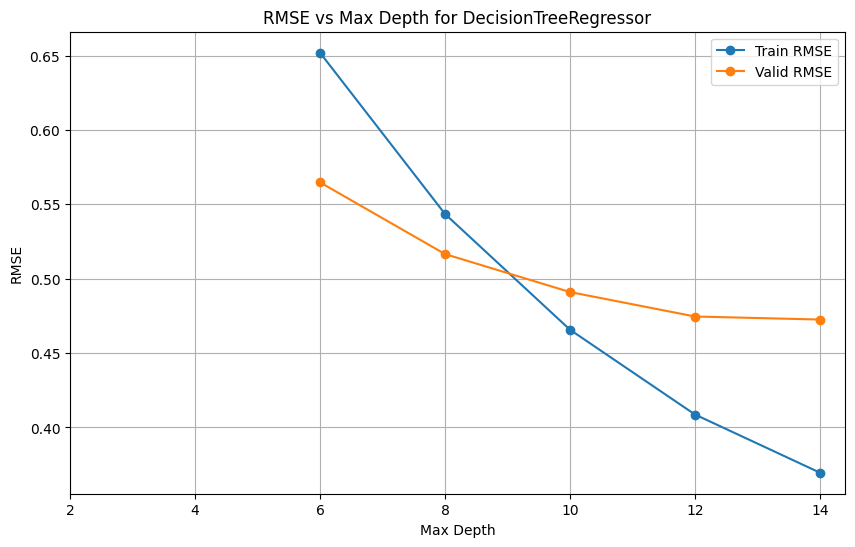

In [13]:
import matplotlib.pyplot as plt

# Fine tune max_depth

max_depth_values = range(6, 16, 2)  # Try depths from 6 to 16

train_rmse = []
valid_rmse = []

for max_depth in max_depth_values:
    
    regressor = XGBRegressor(random_state=42,
                            max_depth=max_depth, 
                            n_estimators=200, 
                            learning_rate=0.05, 
                            subsample = 1.0, 
                            min_child_weight = 5,
                            gamma = 0.1,
                            colsample_bytree = 1.0)

    pipe = make_pipeline(date_encoder, preprocessor, regressor)
    pipe.fit(X_train, y_train)

    rmse_train = mean_squared_error(y_train, pipe.predict(X_train), squared=False)
    train_rmse.append(rmse_train)

    rmse_valid = mean_squared_error(y_valid, pipe.predict(X_valid), squared=False)
    valid_rmse.append(rmse_valid)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_rmse, label="Train RMSE", marker="o")
plt.plot(max_depth_values, valid_rmse, label="Valid RMSE", marker="o")
plt.xlabel("Max Depth")
plt.ylabel("RMSE")
plt.title("RMSE vs Max Depth for DecisionTreeRegressor")
plt.legend()
plt.grid(True)

plt.xticks(range(2, max(max_depth_values) + 1, 2))

plt.show()

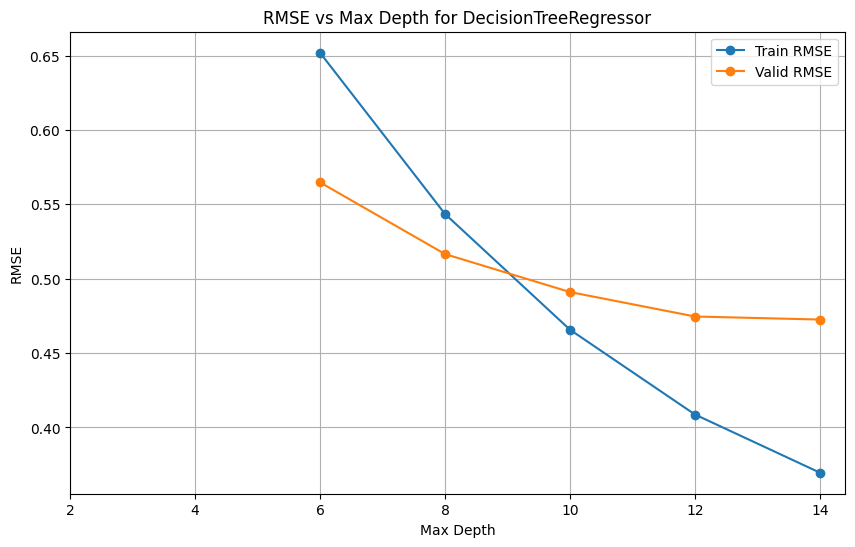

In [10]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_rmse, label="Train RMSE", marker="o")
plt.plot(max_depth_values, valid_rmse, label="Valid RMSE", marker="o")
plt.xlabel("Max Depth")
plt.ylabel("RMSE")
plt.title("RMSE vs Max Depth for DecisionTreeRegressor")
plt.legend()
plt.grid(True)

plt.xticks(range(2, max(max_depth_values) + 1, 2))

plt.show()

In [11]:

#%% Model 2.1: Optimized XGBRegressor 
start_time = time()
regressor = XGBRegressor(random_state=42,
                          max_depth=20, 
                          n_estimators=200, 
                          learning_rate=0.05, 
                          subsample = 1.0, 
                          min_child_weight = 5,
                          gamma = 0.1,
                          colsample_bytree = 1.0)
pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)
elapsed_time = time() - start_time

print(f"XGBRegressor Train RMSE: {mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"XGBRegressor Valid RMSE: {mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")
print(f"Training time XGB: {elapsed_time:.2f} seconds")

# Load the test data
#test_data = pd.read_parquet("/kaggle/input/msdb-2024/final_test.parquet") # to load on Kaggle
test_data = pd.read_parquet(Path("data") / "final_test.parquet") # to load locally
test_data = preprocess_data(test_data)

merged_data = pd.merge(test_data, weather_data, on="date", how="left") # merge test and weather data
merged_data = merged_data.loc[:, ~merged_data.columns.str.endswith(("_x", "_y"))] # Drop redundant date columns 

X_test = merged_data # Extract features (X) for prediction

# Predict on test data
y_pred = pipe.predict(X_test)

# Save predictions
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
output_path = "submission_xgb_2.2.csv"
results.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBRegressor Train RMSE: 0.27


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBRegressor Valid RMSE: 0.46
Training time XGB: 223.18 seconds
Predictions saved to submission_xgb_2.2.csv


Valid RMSE is only slightly improving while train RMSE goes very low.

c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

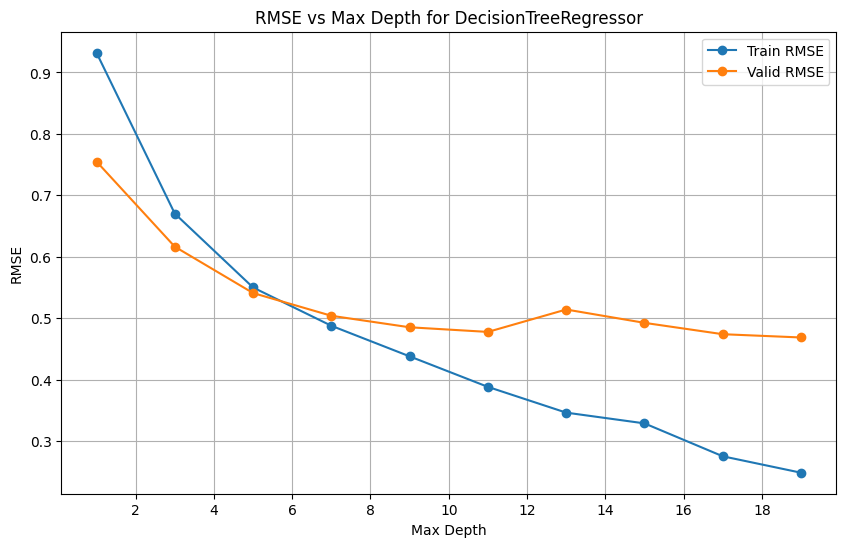

In [12]:
import matplotlib.pyplot as plt

# Fine tune max_depth

max_depth_values = range(1, 20, 2)  # Try depths from 6 to 16

train_rmse = []
valid_rmse = []

for max_depth in max_depth_values:
    
    regressor = XGBRegressor(random_state=42,
                            max_depth=max_depth)

    pipe = make_pipeline(date_encoder, preprocessor, regressor)
    pipe.fit(X_train, y_train)

    rmse_train = mean_squared_error(y_train, pipe.predict(X_train), squared=False)
    train_rmse.append(rmse_train)

    rmse_valid = mean_squared_error(y_valid, pipe.predict(X_valid), squared=False)
    valid_rmse.append(rmse_valid)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_rmse, label="Train RMSE", marker="o")
plt.plot(max_depth_values, valid_rmse, label="Valid RMSE", marker="o")
plt.xlabel("Max Depth")
plt.ylabel("RMSE")
plt.title("RMSE vs Max Depth for DecisionTreeRegressor")
plt.legend()
plt.grid(True)

plt.xticks(range(2, max(max_depth_values) + 1, 2))

plt.show()

Max_Depth of about 10 seems optimal

In [4]:

#%% Model 2.1: Optimized XGBRegressor 
start_time = time()
regressor = XGBRegressor(random_state=42,
                          max_depth=10, 
                          n_estimators=200, 
                          learning_rate=0.05, 
                          subsample = 1.0, 
                          min_child_weight = 5,
                          gamma = 0.1,
                          colsample_bytree = 1.0)
pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)
elapsed_time = time() - start_time

print(f"XGBRegressor Train RMSE: {mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"XGBRegressor Valid RMSE: {mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")
print(f"Training time XGB: {elapsed_time:.2f} seconds")

# Load the test data
#test_data = pd.read_parquet("/kaggle/input/msdb-2024/final_test.parquet") # to load on Kaggle
test_data = pd.read_parquet(Path("data") / "final_test.parquet") # to load locally
test_data = preprocess_data(test_data)

merged_data = pd.merge(test_data, weather_data, on="date", how="left") # merge test and weather data
merged_data = merged_data.loc[:, ~merged_data.columns.str.endswith(("_x", "_y"))] # Drop redundant date columns 

X_test = merged_data # Extract features (X) for prediction

# Predict on test data
y_pred = pipe.predict(X_test)

# Save predictions
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
output_path = "submission_xgb_2.3.csv"
results.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBRegressor Train RMSE: 0.53


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBRegressor Valid RMSE: 0.52
Training time XGB: 15.57 seconds
Predictions saved to submission_xgb_2.3.csv
